# Density estimation using Real NVP

**Authors:** [Mandolini Giorgio Maria](https://www.linkedin.com/in/giorgio-maria-mandolini-a2a1b71b4/), [Sanna Daniele](https://www.linkedin.com/in/daniele-sanna-338629bb/), [Zannini Quirini Giorgio](https://www.linkedin.com/in/giorgio-zannini-quirini-16ab181a0/)<br>
**Date created:** 2020/08/10<br>
**Last modified:** 2020/08/10<br>
**Description:** Estimating the density distribution of the "double moon" dataset.

## Introduction

The aim of this work is to map a simple distribution - which is easy to sample
and whose density is simple to estimate - to a more complex one learned from the data.
This kind of generative model is also known as "normalizing flow".

In order to do this, the model is trained via the maximum
likelihood principle, using the "change of variable" formula.

We will use an affine coupling function. We create it such that its inverse, as well as
the determinant of the Jacobian, are easy to obtain (more details in the referenced paper).

**Requirements:**

* Tensorflow 2.9.1
* Tensorflow probability 0.17.0

**Reference:**

[Density estimation using Real NVP](https://arxiv.org/abs/1605.08803)

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

## Load the data

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

## Affine coupling layer

In [6]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
#    input = keras.layers.Input(shape=input_shape)
    input = keras.layers.Input(shape=(input_shape,))

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])


## Real NVP

In [7]:

class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


## Model training

In [8]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

In [10]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 02:47:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 02:47:21] [setup] RAM Tracking...
[codecarbon INFO @ 02:47:21] [setup] CPU Tracking...
[codecarbon WARNING @ 02:47:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 02:47:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 02:47:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 02:47:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 02:47:22] [setup] GPU Tracking...
[codecarbon INFO @ 02:47:22] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:47:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/300


[codecarbon INFO @ 02:47:37] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:47:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:37] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 02:47:37] Energy consumed for all GPUs : 0.000132 kWh. Total GPU Power : 31.540415452882574 W
[codecarbon INFO @ 02:47:37] 0.000351 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:47:52] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:47:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:47:52] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 02:47:52] Energy consumed for all GPUs : 0.000276 kWh. Total GPU Power : 34.79353589043353 W
[codecarbon INFO @ 02:47:52] 0.000714 kWh of electricity used since the beginning.


10/10 - 35s - 4s/step - loss: 2.6866 - val_loss: 2.5786
Epoch 2/300
10/10 - 3s - 315ms/step - loss: 2.6036 - val_loss: 2.5343
Epoch 3/300
10/10 - 0s - 25ms/step - loss: 2.5505 - val_loss: 2.4944
Epoch 4/300
10/10 - 0s - 21ms/step - loss: 2.4972 - val_loss: 2.4729
Epoch 5/300
10/10 - 0s - 24ms/step - loss: 2.4698 - val_loss: 2.4434
Epoch 6/300
10/10 - 0s - 24ms/step - loss: 2.4402 - val_loss: 2.4211
Epoch 7/300
10/10 - 0s - 27ms/step - loss: 2.4100 - val_loss: 2.3979
Epoch 8/300
10/10 - 0s - 29ms/step - loss: 2.3822 - val_loss: 2.3757
Epoch 9/300
10/10 - 0s - 20ms/step - loss: 2.3603 - val_loss: 2.3434
Epoch 10/300
10/10 - 0s - 23ms/step - loss: 2.3296 - val_loss: 2.3271
Epoch 11/300
10/10 - 0s - 23ms/step - loss: 2.3025 - val_loss: 2.2815
Epoch 12/300
10/10 - 0s - 26ms/step - loss: 2.2632 - val_loss: 2.2598
Epoch 13/300
10/10 - 0s - 20ms/step - loss: 2.2257 - val_loss: 2.2238
Epoch 14/300
10/10 - 0s - 20ms/step - loss: 2.1938 - val_loss: 2.2015
Epoch 15/300
10/10 - 0s - 20ms/step - los

[codecarbon INFO @ 02:48:07] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:48:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:07] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 02:48:07] Energy consumed for all GPUs : 0.000431 kWh. Total GPU Power : 37.07151071047821 W
[codecarbon INFO @ 02:48:07] 0.001087 kWh of electricity used since the beginning.


10/10 - 0s - 22ms/step - loss: 1.8187 - val_loss: 1.8410
Epoch 29/300
10/10 - 0s - 20ms/step - loss: 1.7872 - val_loss: 1.8144
Epoch 30/300
10/10 - 0s - 19ms/step - loss: 1.7404 - val_loss: 1.7770
Epoch 31/300
10/10 - 0s - 18ms/step - loss: 1.6757 - val_loss: 1.7447
Epoch 32/300
10/10 - 0s - 31ms/step - loss: 1.6570 - val_loss: 1.7381
Epoch 33/300
10/10 - 0s - 22ms/step - loss: 1.6492 - val_loss: 1.7189
Epoch 34/300
10/10 - 0s - 27ms/step - loss: 1.6382 - val_loss: 1.6699
Epoch 35/300
10/10 - 0s - 22ms/step - loss: 1.6275 - val_loss: 1.6767
Epoch 36/300
10/10 - 0s - 26ms/step - loss: 1.5961 - val_loss: 1.6528
Epoch 37/300
10/10 - 0s - 38ms/step - loss: 1.5954 - val_loss: 1.6514
Epoch 38/300
10/10 - 0s - 30ms/step - loss: 1.5782 - val_loss: 1.6493
Epoch 39/300
10/10 - 0s - 27ms/step - loss: 1.5473 - val_loss: 1.6335
Epoch 40/300
10/10 - 0s - 26ms/step - loss: 1.5596 - val_loss: 1.6300
Epoch 41/300
10/10 - 0s - 31ms/step - loss: 1.5370 - val_loss: 1.6010
Epoch 42/300
10/10 - 0s - 31ms/st

[codecarbon INFO @ 02:48:22] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:48:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:22] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 02:48:22] Energy consumed for all GPUs : 0.000634 kWh. Total GPU Power : 48.849818992402156 W
[codecarbon INFO @ 02:48:22] 0.001509 kWh of electricity used since the beginning.


10/10 - 0s - 28ms/step - loss: 1.4376 - val_loss: 1.5538
Epoch 89/300
10/10 - 0s - 29ms/step - loss: 1.4202 - val_loss: 1.4974
Epoch 90/300
10/10 - 0s - 31ms/step - loss: 1.4030 - val_loss: 1.4920
Epoch 91/300
10/10 - 0s - 27ms/step - loss: 1.3994 - val_loss: 1.6463
Epoch 92/300
10/10 - 0s - 19ms/step - loss: 1.4061 - val_loss: 1.4785
Epoch 93/300
10/10 - 0s - 31ms/step - loss: 1.3891 - val_loss: 1.4556
Epoch 94/300
10/10 - 0s - 33ms/step - loss: 1.4617 - val_loss: 1.4693
Epoch 95/300
10/10 - 0s - 20ms/step - loss: 1.3891 - val_loss: 1.4181
Epoch 96/300
10/10 - 0s - 23ms/step - loss: 1.3686 - val_loss: 1.4489
Epoch 97/300
10/10 - 0s - 26ms/step - loss: 1.3812 - val_loss: 1.4053
Epoch 98/300
10/10 - 0s - 31ms/step - loss: 1.3441 - val_loss: 1.5042
Epoch 99/300
10/10 - 0s - 23ms/step - loss: 1.3648 - val_loss: 1.4494
Epoch 100/300
10/10 - 0s - 26ms/step - loss: 1.3426 - val_loss: 1.4667
Epoch 101/300
10/10 - 0s - 34ms/step - loss: 1.3785 - val_loss: 1.4402
Epoch 102/300
10/10 - 0s - 19ms

[codecarbon INFO @ 02:48:37] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:48:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:37] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 02:48:37] Energy consumed for all GPUs : 0.000814 kWh. Total GPU Power : 43.09321829545207 W
[codecarbon INFO @ 02:48:37] 0.001907 kWh of electricity used since the beginning.


10/10 - 0s - 35ms/step - loss: 1.2989 - val_loss: 1.3861
Epoch 145/300
10/10 - 0s - 25ms/step - loss: 1.4256 - val_loss: 1.4162
Epoch 146/300
10/10 - 0s - 18ms/step - loss: 1.3675 - val_loss: 1.4055
Epoch 147/300
10/10 - 0s - 34ms/step - loss: 1.3283 - val_loss: 1.3573
Epoch 148/300
10/10 - 0s - 26ms/step - loss: 1.3301 - val_loss: 1.6824
Epoch 149/300
10/10 - 0s - 34ms/step - loss: 1.4500 - val_loss: 1.3957
Epoch 150/300
10/10 - 0s - 30ms/step - loss: 1.3698 - val_loss: 1.3640
Epoch 151/300
10/10 - 0s - 31ms/step - loss: 1.4144 - val_loss: 1.4356
Epoch 152/300
10/10 - 0s - 20ms/step - loss: 1.4176 - val_loss: 1.4814
Epoch 153/300
10/10 - 0s - 33ms/step - loss: 1.3851 - val_loss: 1.3744
Epoch 154/300
10/10 - 0s - 26ms/step - loss: 1.3472 - val_loss: 1.3525
Epoch 155/300
10/10 - 0s - 33ms/step - loss: 1.3318 - val_loss: 1.4159
Epoch 156/300
10/10 - 0s - 30ms/step - loss: 1.3425 - val_loss: 1.3365
Epoch 157/300
10/10 - 0s - 23ms/step - loss: 1.3501 - val_loss: 1.4295
Epoch 158/300
10/10 

[codecarbon INFO @ 02:48:52] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:48:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:48:52] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 02:48:52] Energy consumed for all GPUs : 0.001005 kWh. Total GPU Power : 45.93614174201394 W
[codecarbon INFO @ 02:48:52] 0.002317 kWh of electricity used since the beginning.


10/10 - 0s - 32ms/step - loss: 1.3641 - val_loss: 1.4385
Epoch 201/300
10/10 - 0s - 23ms/step - loss: 1.3479 - val_loss: 1.4012
Epoch 202/300
10/10 - 0s - 31ms/step - loss: 1.3491 - val_loss: 1.3712
Epoch 203/300
10/10 - 0s - 19ms/step - loss: 1.3204 - val_loss: 1.3504
Epoch 204/300
10/10 - 0s - 23ms/step - loss: 1.3094 - val_loss: 1.3571
Epoch 205/300
10/10 - 0s - 19ms/step - loss: 1.2942 - val_loss: 1.3248
Epoch 206/300
10/10 - 0s - 31ms/step - loss: 1.2881 - val_loss: 1.3604
Epoch 207/300
10/10 - 0s - 33ms/step - loss: 1.2900 - val_loss: 1.3632
Epoch 208/300
10/10 - 0s - 30ms/step - loss: 1.2717 - val_loss: 1.3306
Epoch 209/300
10/10 - 0s - 26ms/step - loss: 1.2877 - val_loss: 1.3323
Epoch 210/300
10/10 - 0s - 20ms/step - loss: 1.3736 - val_loss: 1.7835
Epoch 211/300
10/10 - 0s - 23ms/step - loss: 1.3534 - val_loss: 1.3198
Epoch 212/300
10/10 - 0s - 19ms/step - loss: 1.2886 - val_loss: 1.3162
Epoch 213/300
10/10 - 0s - 30ms/step - loss: 1.3323 - val_loss: 1.3696
Epoch 214/300
10/10 

[codecarbon INFO @ 02:49:07] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:49:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:07] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 02:49:07] Energy consumed for all GPUs : 0.001187 kWh. Total GPU Power : 43.777881890326704 W
[codecarbon INFO @ 02:49:07] 0.002718 kWh of electricity used since the beginning.


10/10 - 0s - 30ms/step - loss: 1.3155 - val_loss: 1.3377
Epoch 259/300
10/10 - 0s - 34ms/step - loss: 1.2838 - val_loss: 1.3258
Epoch 260/300
10/10 - 0s - 26ms/step - loss: 1.2754 - val_loss: 1.3318
Epoch 261/300
10/10 - 0s - 20ms/step - loss: 1.2681 - val_loss: 1.3448
Epoch 262/300
10/10 - 0s - 33ms/step - loss: 1.2731 - val_loss: 1.3859
Epoch 263/300
10/10 - 0s - 22ms/step - loss: 1.2778 - val_loss: 1.3483
Epoch 264/300
10/10 - 0s - 31ms/step - loss: 1.3115 - val_loss: 1.4113
Epoch 265/300
10/10 - 0s - 27ms/step - loss: 1.2970 - val_loss: 1.3449
Epoch 266/300
10/10 - 0s - 27ms/step - loss: 1.2591 - val_loss: 1.3527
Epoch 267/300
10/10 - 0s - 28ms/step - loss: 1.2752 - val_loss: 1.3679
Epoch 268/300
10/10 - 0s - 28ms/step - loss: 1.2776 - val_loss: 1.3512
Epoch 269/300
10/10 - 0s - 32ms/step - loss: 1.2757 - val_loss: 1.3637
Epoch 270/300
10/10 - 0s - 26ms/step - loss: 1.2911 - val_loss: 1.4567
Epoch 271/300
10/10 - 0s - 31ms/step - loss: 1.3077 - val_loss: 1.3109
Epoch 272/300
10/10 

[codecarbon INFO @ 02:49:19] Energy consumed for RAM : 0.000323 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:49:19] Delta energy consumed for CPU with constant : 0.000135 kWh, power : 42.5 W
[codecarbon INFO @ 02:49:19] Energy consumed for All CPU : 0.001375 kWh
[codecarbon INFO @ 02:49:19] Energy consumed for all GPUs : 0.001331 kWh. Total GPU Power : 44.92717636624255 W
[codecarbon INFO @ 02:49:19] 0.003029 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:49:19] 0.012238 g.CO2eq/s mean an estimation of 385.9342031883958 kg.CO2eq/year


Emissions during training: 0.0014258255161595235 kg CO2


In [11]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.003029 kWh
Execution Time: 116.51 seconds
Emissions: 0.0014258255161595235 kg CO2


## Performance evaluation

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


(-2.0, 2.0)

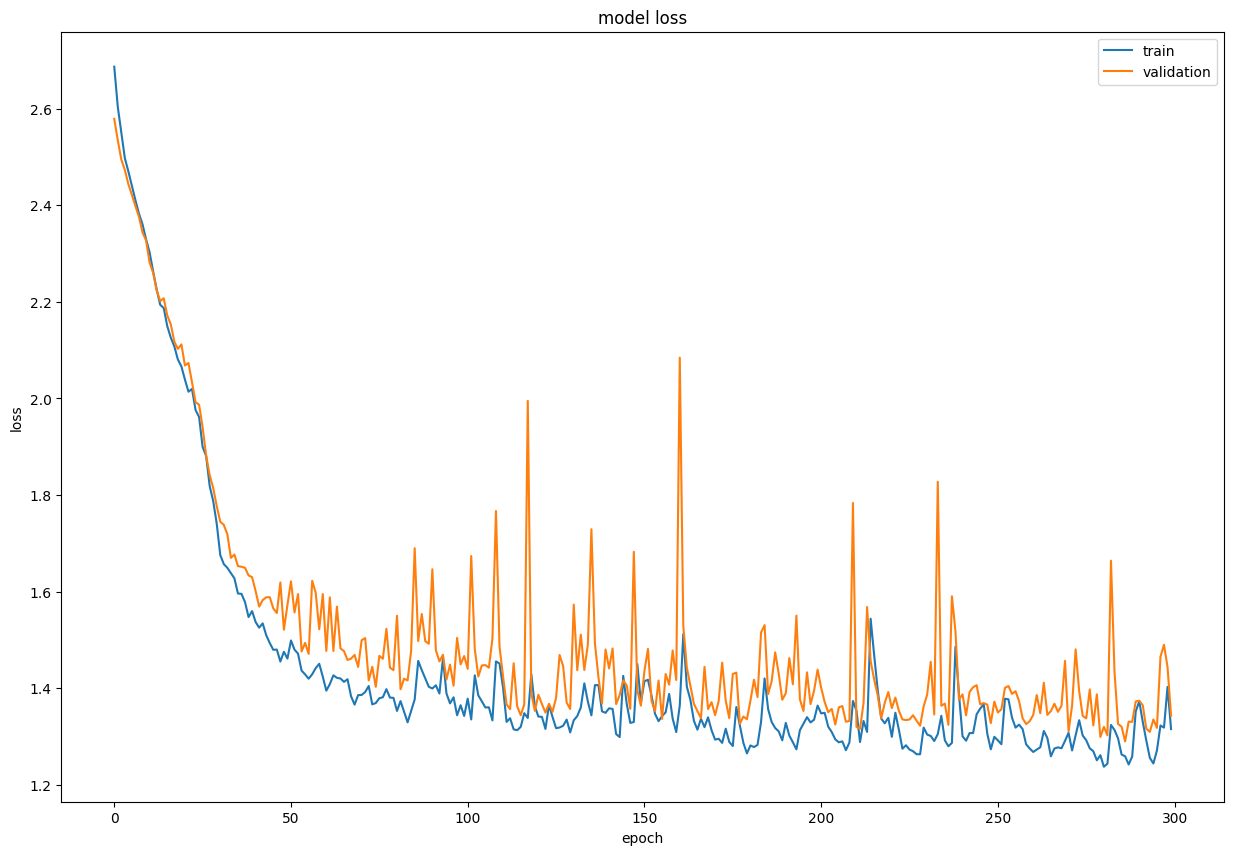

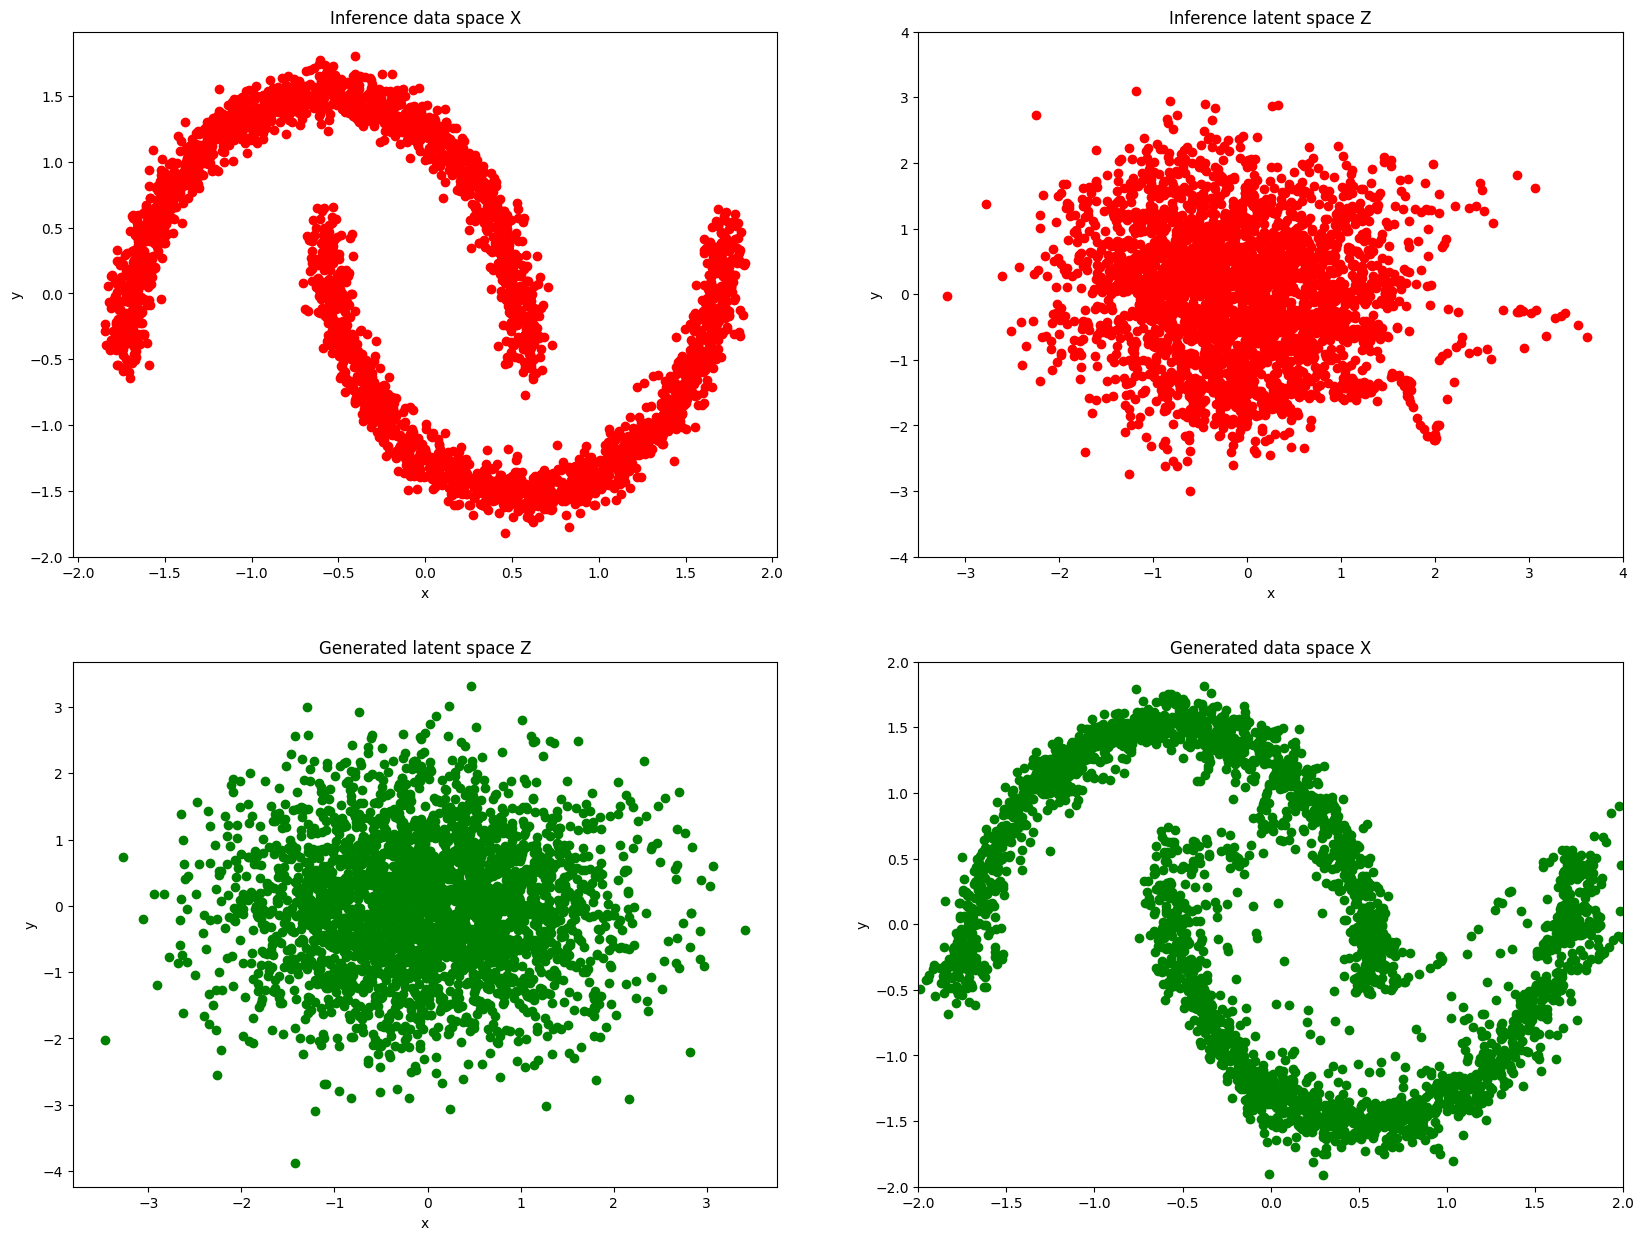

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])